# Intercambio de pares: búsqueda de pares basados ​​en agrupación

En este estudio de caso, utilizaremos métodos de agrupación para seleccionar pares para el comercio de pares.
estrategia.

## Content

* [1. Definición del problema](#0)
* [2. Primeros pasos: cargar bibliotecas y conjuntos de datos](#1)
	* [2.1. Cargar bibliotecas](#1.1)
	* [2.2. Cargar conjunto de datos](#1.2)
* [3. Análisis de datos exploratorios](#2)
	* [3.1 Estadísticas Descriptivas](#2.1)
* [4. Preparación de datos](#3)
	* [4.1 Limpieza de datos](#3.1)
	* [4.2.Transformación de datos](#3.2)
* [5. Evaluar algoritmos y modelos](#5)
	* [5.1. Agrupación de k-medias](#5.1)
		* [5.1.1 Encontrar el número correcto de grupos](#5.1.1)
		* [5.1.2 Agrupación y visualización](#5.1.2)
	* [5.2. Agrupación jerárquica (agrupación aglomerativa)](#5.2)
		* [5.2.1. Construcción de gráfico de jerarquía/dendograma](#5.2.1)
		* [5.2.2. Agrupación y visualización](#5.2.1)
	* [5.3. Agrupación de propagación por afinidad](#5.3)
		* [5.3.1 Visualizando el cluster](#5.2.1)
	* [5.4. Evaluación de cluster](#5.4)
* [6.Selección de pares](#6)
	* [6.1 Función de cointegración y selección de pares](#6.1)
	* [6.2. Visualización de pares](#6.2)zación de pares](#6.2)

<a id='0'></a>
# 1. Definición del problema

Nuestro objetivo en este estudio de caso es realizar un análisis de agrupación de las acciones del S&P500 y generar pares para una estrategia de negociación de pares.


Los datos de las acciones del S&P 500, obtenidos utilizando pandas_datareader de yahoo Finance. Incluye datos de precios desde 2018 en adelante.

<a id='1'></a>
# 2. Primeros pasos: cargar bibliotecas y conjuntos de datos

<a id='1.1'></a>
## 2.1. Cargar bibliotecas

In [1]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr

# modelo
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


# otros
import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Cargar conjunto de datos

In [2]:
dataset = read_csv('SP500Data.csv',index_col=0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Análisis de datos exploratorios

<a id='2.1'></a>
## 3.1. Estadísticas Descriptivas

In [5]:
# shape
dataset.shape

(448, 502)

In [6]:
set_option('display.width', 100)
dataset.head(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998
2018-01-04,58.820000,99.379997,199.250000,156.380005,64.660004,183.220001,12.12,111.000000,10.83,198.539993,...,151.259995,163.399994,47.119999,29.690001,70.489998,69.360001,82.360001,124.739998,50.849998,72.529999
2018-01-05,58.990002,101.110001,202.320007,157.669998,66.370003,185.339996,11.88,112.180000,10.87,199.470001,...,152.229996,164.490005,46.790001,29.910000,74.150002,69.230003,82.839996,125.980003,50.869999,73.360001
2018-01-08,58.820000,99.489998,207.800003,158.929993,66.629997,185.039993,12.28,111.389999,10.87,200.529999,...,151.410004,162.300003,47.139999,30.260000,74.639999,69.480003,82.980003,126.220001,50.619999,74.239998


In [7]:
# estadisticos básicos
dataset.describe()

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,...,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,70.934196,88.078013,307.303839,167.473750,59.630804,252.270603,21.804754,147.501428,14.534888,128.423750,...,165.139486,139.475335,51.671027,29.151071,90.774487,74.549040,93.492455,120.406161,49.230245,94.787232
std,9.015754,13.480891,71.989893,14.635497,13.119012,29.001055,7.425020,21.095302,2.266254,38.573308,...,17.383970,29.251895,6.650626,3.450413,21.081242,4.926937,11.958700,9.199975,4.820335,14.395919
min,56.270000,62.980000,159.309998,133.669998,40.110001,177.699997,9.530000,103.760002,10.060000,71.800003,...,134.839996,92.010002,42.130001,18.920000,62.820000,61.380001,76.300003,97.230003,38.509998,71.510002
25%,62.620001,78.657503,260.557487,157.280006,47.037500,235.377495,15.147500,133.307499,12.847500,94.059998,...,151.705002,114.085001,45.689999,27.139999,71.664999,70.547503,83.507502,114.030001,45.107500,84.557499
50%,70.014999,88.524998,301.940002,162.880005,55.269999,254.684998,21.885000,154.949997,14.830000,113.389999,...,158.809998,132.974998,49.370001,29.075000,85.195000,75.165001,89.930000,120.645000,49.184999,90.090000
75%,78.620003,96.667498,368.095001,178.337502,71.565002,272.989990,28.437500,163.614998,16.355000,158.855000,...,178.064999,164.927498,56.715001,31.455000,109.367500,78.359999,101.462500,125.850002,53.214999,101.970001
max,88.739998,123.209999,449.750000,201.119995,83.389999,311.269989,34.389999,184.720001,18.410000,215.759995,...,199.360001,201.509995,65.820000,36.480000,139.720001,84.410004,119.209999,142.610001,58.540001,128.470001


<a id='3'></a>
## 4. Preparación de datos

<a id='3.1'></a>
## 4.1. Limpieza de datos
Comprobamos los NA en las filas, los eliminamos o los completamos con la media de la columna.

In [8]:
# Comprobando cualquier valor nulo
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Eliminar las columnas con más del 30% de valores faltantes.

In [9]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

CTVA    0.781250
DOW     0.678571
FOX     0.667411
FOXA    0.665179
NOV     0.000000
MSI     0.000000
MSCI    0.000000
MYL     0.000000
NDAQ    0.000000
ABT     0.000000
dtype: float64

In [10]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print('Columnas a eliminar: ', drop_list)

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

Columnas a eliminar:  ['CTVA', 'DOW', 'FOX', 'FOXA']


(448, 498)

Dado que existen valores nulos, elimine las filas que contienen los valores nulos.

In [11]:
# Complete los valores faltantes con el último valor disponible en el conjunto de datos.
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,58.790001,98.410004,192.490005,153.839996,64.309998,177.699997,10.98,106.089996,10.88,203.039993,...,146.990005,164.300003,47.810001,29.370001,67.879997,68.070000,81.599998,124.059998,50.700001,71.769997
2018-01-03,58.919998,99.949997,195.820007,154.550003,65.309998,181.039993,11.55,107.050003,10.87,202.119995,...,149.740005,162.520004,47.490002,29.330000,69.239998,68.900002,81.529999,124.919998,50.639999,72.099998


<a id='3.2'></a>
## 4.2. Transformación de datos

A los efectos de la agrupación, utilizaremos los rendimientos y la varianza anuales como variables, ya que son indicadores del rendimiento de las acciones y su volatilidad. Preparemos las variables de rentabilidad y volatilidad a partir de los datos.

In [12]:
# Calcule el rendimiento porcentual anual promedio y las volatilidades durante un período teórico de un año.
# pct_change = (val_actual - val_posterior) / val_posterior
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns

Todas las variables deben estar en la misma escala antes de aplicar la agrupación; de lo contrario, una característica con valores grandes dominará el resultado. Usamos StandardScaler en sklearn para estandarizar las características del conjunto de datos en una escala unitaria (media = 0 y varianza = 1).

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)

rescaledDataset.head(2)
X=rescaledDataset
X.head(2)

,Returns,Volatility
ABT,0.794067,-0.702741
ABBV,-0.927603,0.794867


Los parámetros de los clusters son los índices y las variables utilizadas en el clustering son las columnas. Por lo tanto, los datos están en el formato correcto para ser enviados a los algoritmos de agrupación.

<a id='4'></a>
# 5. Evaluar algoritmos y modelos

Observaremos los siguientes modelos:

1. KMeans
2. Hierarchical Clustering (Agglomerative Clustering)
3. Affinity Propagation 

<a id='5.1'></a>
## 5.1. K-Means Clustering


<a id='5.1.1'></a>
### 5.1.1. Encontrar el número correcto de grupos

En este paso observamos las siguientes matrices:

1. Suma de errores cuadrados (SSE) dentro de los conglomerados
2. Puntaje de silueta.

Distortion for 2 clusters: 569.402892256897
Distortion for 3 clusters: 432.9041851468119
Distortion for 4 clusters: 311.5237485709396
Distortion for 5 clusters: 251.6909799385852
Distortion for 6 clusters: 218.2650883889336
Distortion for 7 clusters: 191.16661169312374
Distortion for 8 clusters: 166.36694053915264
Distortion for 9 clusters: 149.3315430636036
Distortion for 10 clusters: 136.80377333839388
Distortion for 11 clusters: 121.78859009912125
Distortion for 12 clusters: 110.88304359398288
Distortion for 13 clusters: 101.56309543731926
Distortion for 14 clusters: 94.66162818964155
Distortion for 15 clusters: 87.79995448262744
Distortion for 16 clusters: 81.50687745016734
Distortion for 17 clusters: 76.49432726057539
Distortion for 18 clusters: 71.80110462926218
Distortion for 19 clusters: 66.76855914625308


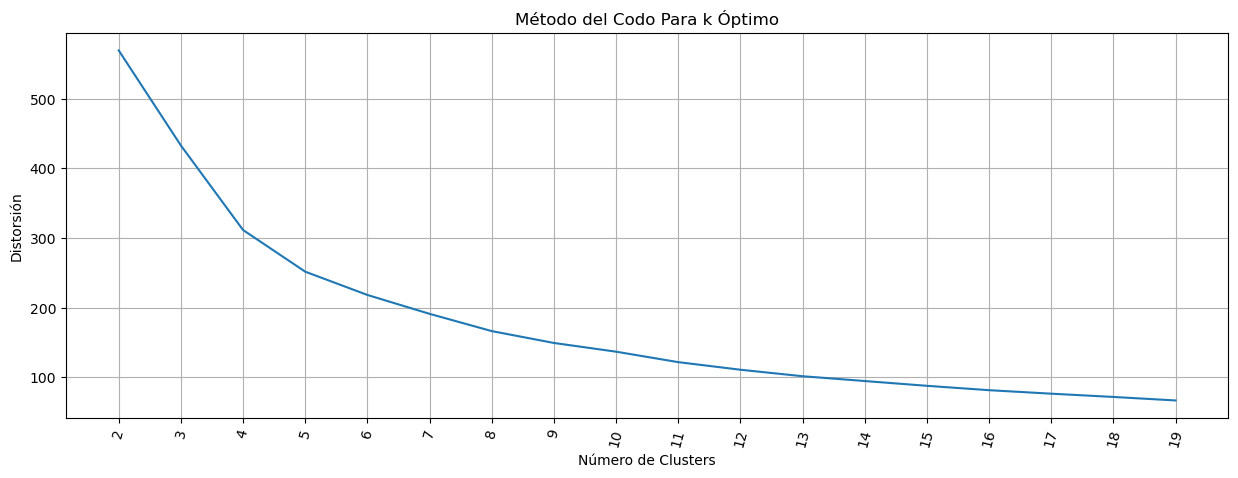

In [14]:
distorsions = []
max_loop = 20

# Iterar sobre diferentes números de clusters
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)  # Inicializar el modelo KMeans con k clusters
    kmeans.fit(X)  # Ajustar el modelo a los datos
    inertia = kmeans.inertia_  # Obtener la inercia (distorsión) del modelo
    distorsions.append(inertia)  # Agregar la inercia a la lista de distorsiones
    print(f"Distortion for {k} clusters: {inertia}")  # Imprimir la inercia para k clusters

# Crear una figura para la gráfica
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)  # Graficar el número de clusters vs la distorsión
plt.xticks([i for i in range(2, max_loop)], rotation=75)  # Ajustar las etiquetas del eje x
plt.xlabel('Número de Clusters')  # Etiqueta del eje x
plt.ylabel('Distorsión')  # Etiqueta del eje y
plt.title('Método del Codo Para k Óptimo')  # Título de la gráfica
plt.grid(True)  # Mostrar la cuadrícula en la gráfica
plt.show()  # Mostrar la gráfica

Al inspeccionar el gráfico basado en SSE, parece que el "pliegue" del codo ocurre 5 o 6 "grupos" para estos datos. Ciertamente, podemos ver que a medida que el número de conglomerados aumenta hasta llegar a 6, la suma de los cuadrados de los errores dentro de los conglomerados se estabiliza.

#### Silhouette score - Puntaje de silueta

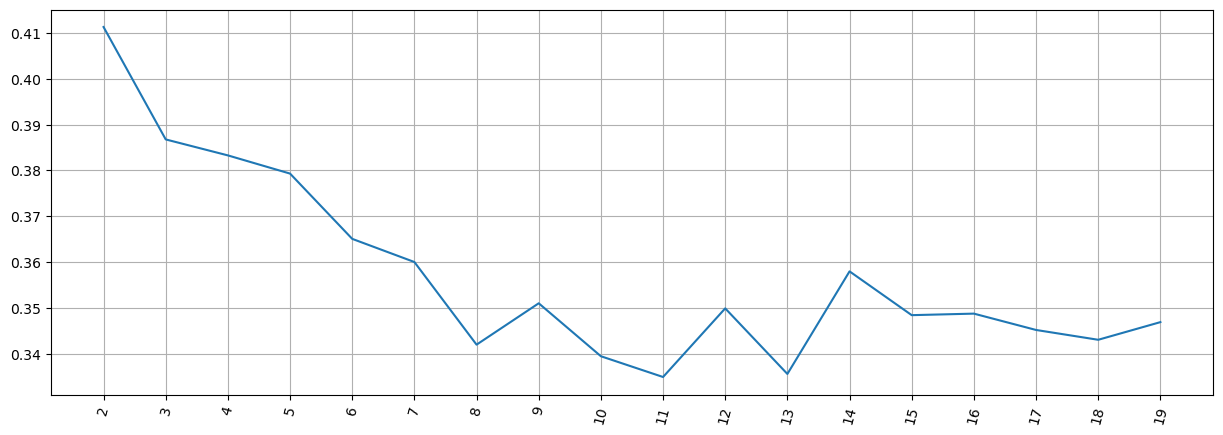

In [15]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

En el gráfico de puntuación de la silueta, podemos ver que hay varias partes del gráfico en las que se puede ver un punto torcido. Dado que no hay mucha diferencia en SSE después de 6 grupos, preferiríamos 6 grupos en el modelo K-medias.

<a id='5.1.2'></a>
### 5.1.2.  Agrupación y visualización

Construyamos el modelo k-medias con seis grupos y visualicemos los resultados.

In [16]:
nclust=6

In [17]:
# entrenar el modeo
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=6)

In [18]:
# Extracción de etiquetas
target_labels = k_means.predict(X)

Visualizar cómo se forman sus conglomerados no es una tarea fácil cuando la cantidad de variables/dimensiones en su conjunto de datos es muy grande. Uno de los métodos para visualizar un grupo en un espacio bidimensional.

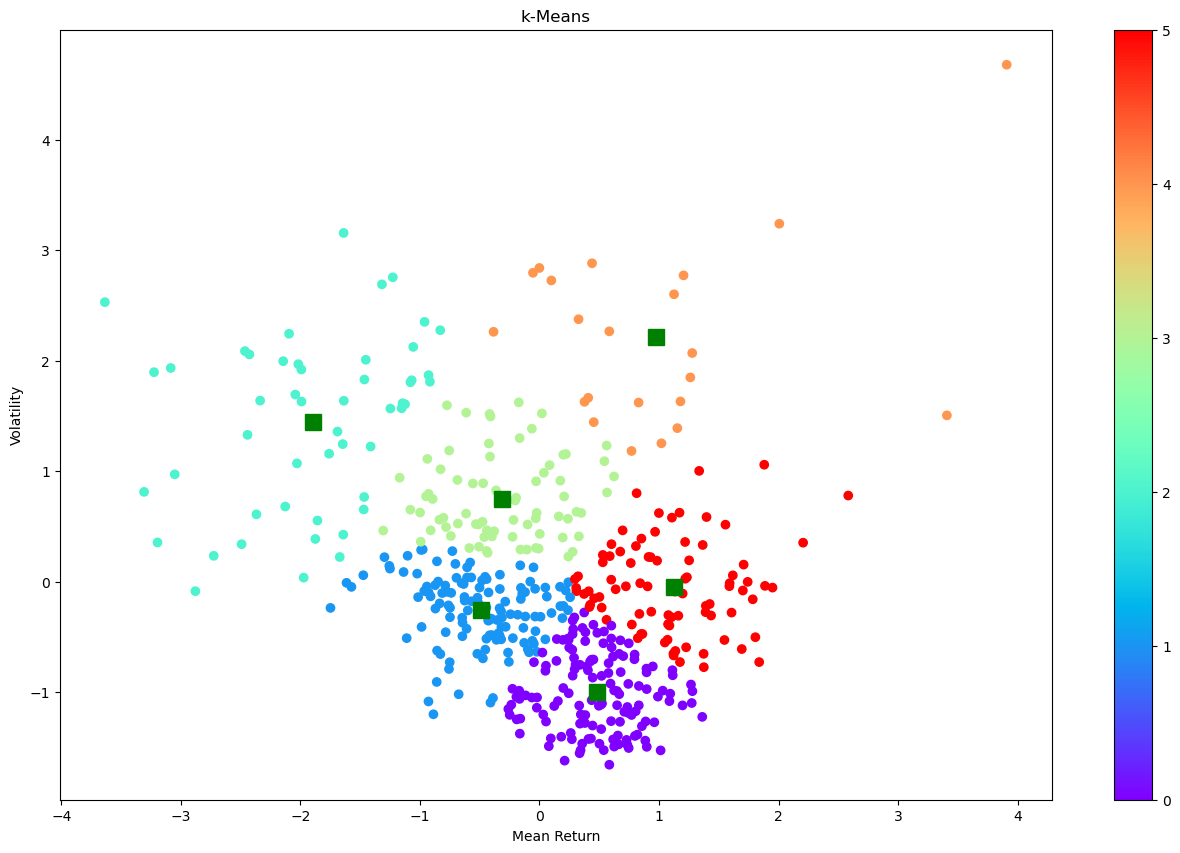

In [19]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

Comprobemos los elementos de los clusters.

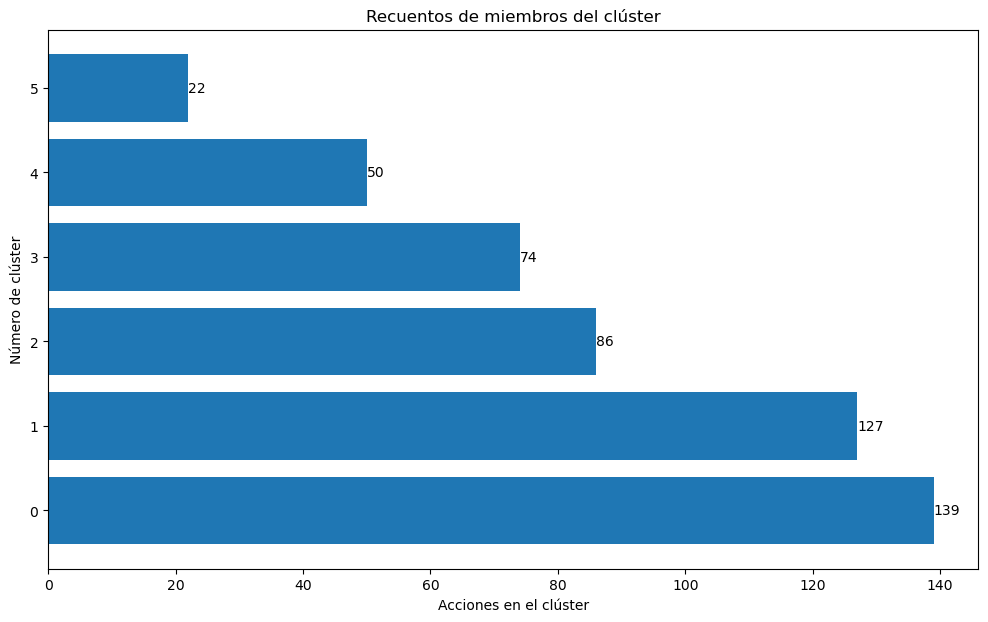

In [20]:
# Crear una serie con las etiquetas de los clusters
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())

# Crear una serie con todas las etiquetas de los clusters
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())

# Filtrar las etiquetas que no son -1 (esto es relevante si estás utilizando clustering jerárquico o DBSCAN)
clustered_series = clustered_series[clustered_series != -1]

# Graficar los recuentos de miembros de cada clúster
plt.figure(figsize=(12, 7))
counts = clustered_series.value_counts()
bars = plt.barh(
    range(len(counts)),  # Etiquetas de los clusters, eje y
    counts  # Cantidad de acciones en cada clúster, eje x
)

# Añadir etiquetas a las barras
for bar in bars:
    plt.text(
        bar.get_width(),  # Posición en el eje x
        bar.get_y() + bar.get_height() / 2,  # Posición en el eje y
        f'{int(bar.get_width())}',  # Texto a mostrar
        va='center'  # Alineación vertical
    )

plt.title('Recuentos de miembros del clúster')
plt.xlabel('Acciones en el clúster')
plt.ylabel('Número de clúster')
plt.show()

El número de acciones en un grupo oscila entre 40 y 120. Aunque la distribución no es igual, tenemos un número significativo de acciones en cada grupo.

<a id='5.2'></a>
## 5.2. Hierarchical Clustering (Agglomerative Clustering)

En el primer paso, observamos el gráfico de jerarquía y comprobamos el número de grupos.

<a id='5.2.1'></a>
### 5.2.1. Construcción de gráfico de jerarquía/dendograma

La clase de jerarquía tiene un método de dendrograma que toma el valor devuelto por el método de vinculación de la misma clase. El método de vinculación "linkage" toma el conjunto de datos y el método para minimizar distancias como parámetros. Usamos 'ward' como método ya que minimiza las variantes de distancias entre los grupos.

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

# Calcular linkage
Z= linkage(X, method='ward')
Z[0]

array([3.30000000e+01, 3.14000000e+02, 3.62580431e-03, 2.00000000e+00])

La mejor manera de visualizar un algoritmo de agrupamiento de aglomerados es a través de un dendograma, que muestra un árbol de grupos, donde las hojas son las cepas individuales y la raíz es el grupo único final. La "distancia" entre cada grupo se muestra en el eje y y, por lo tanto, cuanto más largas sean las ramas, menos correlacionados estarán dos grupos.

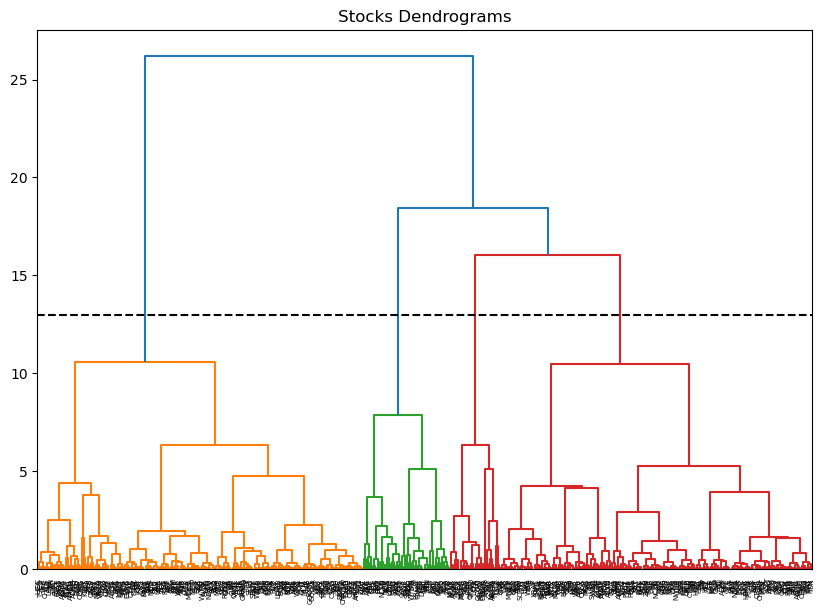

In [22]:
# Plot Dendograma
plt.figure(figsize = (10, 7))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)

plt.axhline(y = 13, color = 'black', linestyle = '--')
plt.show()

Una vez que se forma un grupo grande, se selecciona la distancia vertical más larga sin que ninguna línea horizontal la atraviese y se dibuja una línea horizontal a través de ella. El número de líneas verticales por las que pasa esta línea horizontal recién creada es igual al número de grupos.
Luego seleccionamos el umbral de distancia para cortar el dendrograma y obtener el nivel de agrupamiento seleccionado. La salida es el grupo etiquetado para cada fila de datos. Como se esperaba del dendrograma, un corte en 13 nos da cuatro grupos.

In [23]:
distance_threshold = 13
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([1, 4, 3, 2], dtype=int32)

<a id='5.2.2'></a>
### 5.2.2.  Agrupación y visualización

In [24]:
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

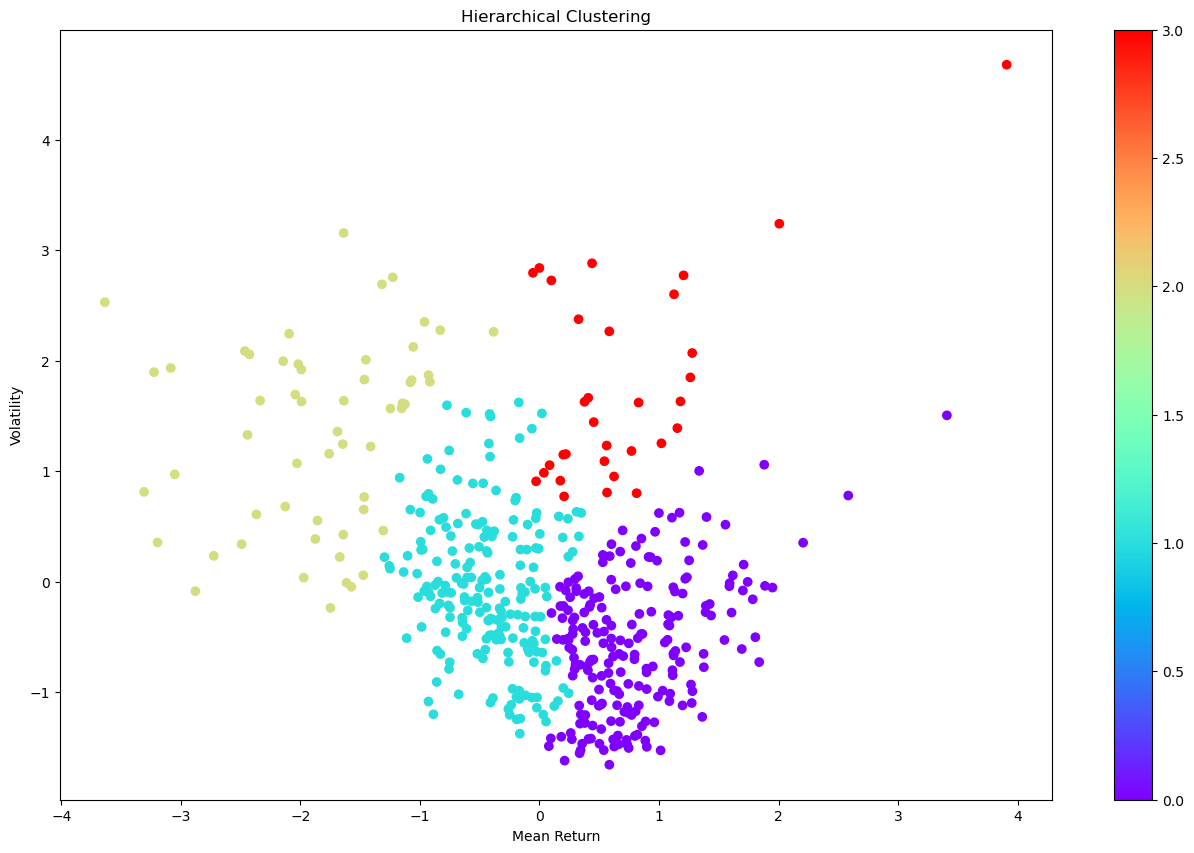

In [25]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

De manera similar al gráfico de agrupación de k-medias, vemos que hay algunos grupos distintos separados por diferentes colores.

<a id='5.3'></a>
## 5.3. Agrupación de propagación por afinidad

In [26]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

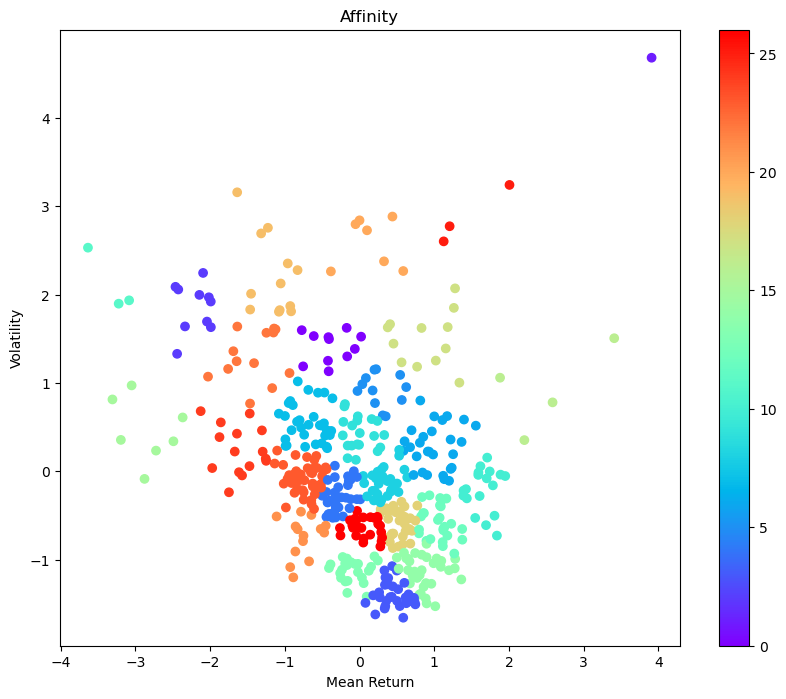

In [27]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

De manera similar al gráfico de agrupación de k-medias, vemos que hay algunos grupos distintos separados por diferentes colores.

<a id='5.3.1'></a>
### 5.3.1 Visualizando el cluster

In [28]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Número estimado de grupos: 27


<Figure size 640x480 with 0 Axes>

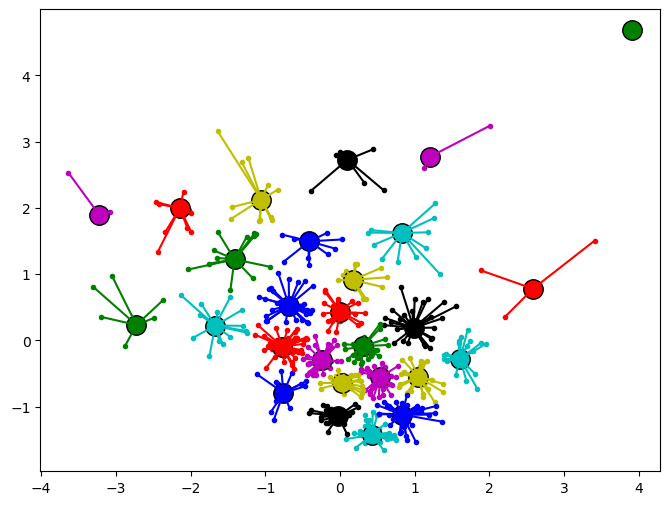

In [29]:
no_clusters = len(cluster_centers_indices)
print('Número estimado de grupos: %d' % no_clusters)
# Plot

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

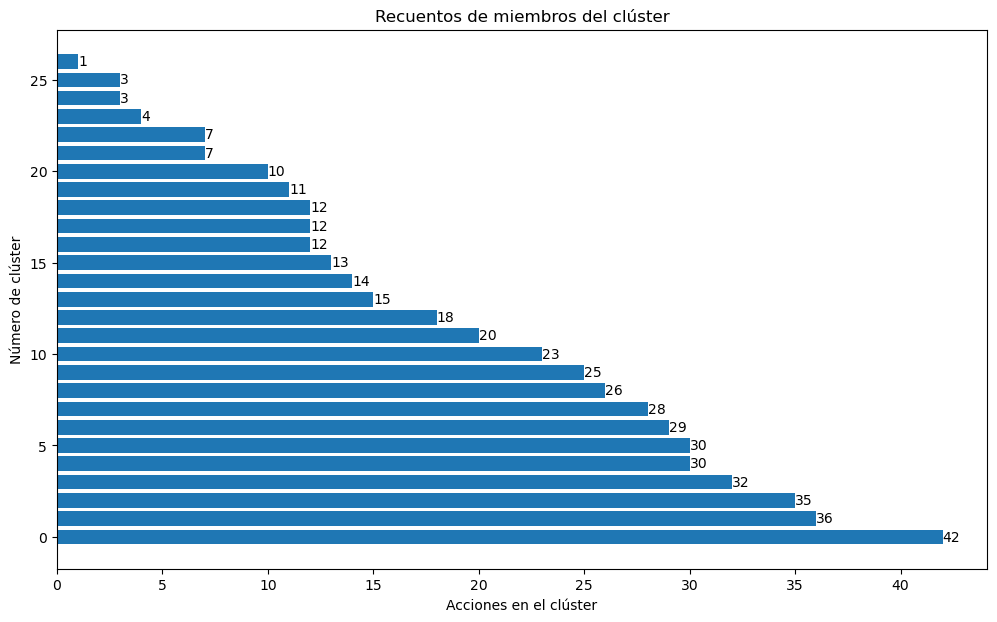

In [30]:
# Crear una serie con las etiquetas de los clusters
clustered_series_ap = pd.Series(index = X.index, data = ap.labels_.flatten())

# Crear una serie con todas las etiquetas de los clusters
clustered_series_all_ap = pd.Series(index = X.index, data = ap.labels_.flatten())

# Filtrar las etiquetas que no son -1 (esto es relevante si estás utilizando clustering jerárquico o DBSCAN)
clustered_series_ap = clustered_series_ap[clustered_series != -1]

# Graficar los recuentos de miembros de cada clúster
plt.figure(figsize=(12, 7))
counts = clustered_series_ap.value_counts()
bars = plt.barh(
    range(len(counts)),  # Etiquetas de los clusters, eje y
    counts  # Cantidad de acciones en cada clúster, eje x
)

# Añadir etiquetas a las barras
for bar in bars:
    plt.text(
        bar.get_width(),  # Posición en el eje x
        bar.get_y() + bar.get_height() / 2,  # Posición en el eje y
        f'{int(bar.get_width())}',  # Texto a mostrar
        va='center'  # Alineación vertical
    )

plt.title('Recuentos de miembros del clúster')
plt.xlabel('Acciones en el clúster')
plt.ylabel('Número de clúster')
plt.show()

<a id='5.4'></a>
## 5.4. Evaluación de cluster

Si no se conocen las etiquetas de verdad del terreno, la evaluación debe realizarse utilizando el modelo mismo. El Coeficiente de silueta (sklearn.metrics.silhouette_score) es un ejemplo de dicha evaluación, donde una puntuación más alta del Coeficiente de silueta se relaciona con un modelo con grupos mejor definidos. El Coeficiente de Silueta se define para cada muestra y se compone de dos puntuaciones:

In [31]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.3514598648200163
hc 0.3432149515640864
ap 0.3450647315156526


Dado que la propagación por afinidad funciona mejor, seguimos adelante con la propagación por afinidad y utilizamos 27 clústeres como lo especifica este método de agrupación.

### Visualizando el retorno dentro de un cluster

Para comprender la intuición detrás de la agrupación, visualicemos los resultados de las agrupaciones.


In [32]:
# todas las existencias con su etiqueta de grupo (incluido -1)
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())

# acciones agrupadas con su etiqueta de agrupación
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [33]:
# obtener el número de acciones en cada grupo
counts = clustered_series_ap.value_counts()

# visualicemos algunos clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[25, 11, 16, 20, 15, 2, 0, 19, 17, 5, 22, 21, 24, 10, 9, 13]

In [34]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clústeres formados: %d" % len(ticker_count_reduced))
print ("Parejas para evaluar: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clústeres formados: 26
Parejas para evaluar: 12166


In [35]:
# Trazar una muestra de los grupos más pequeños.
plt.figure(figsize=(12,7))
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

[25, 11, 16, 20]

<Figure size 1200x700 with 0 Axes>

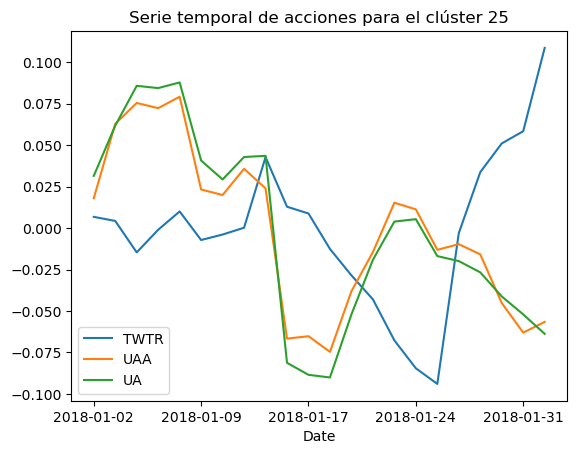

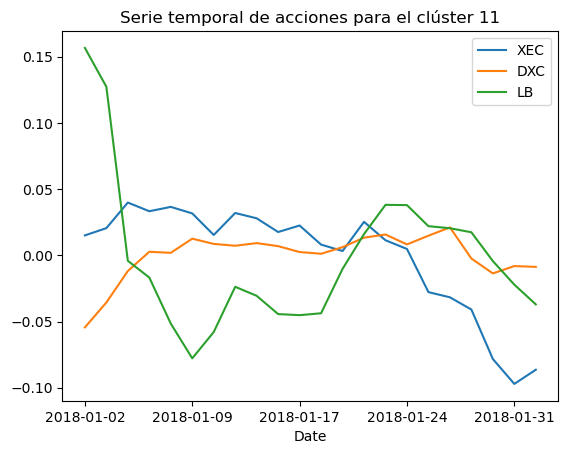

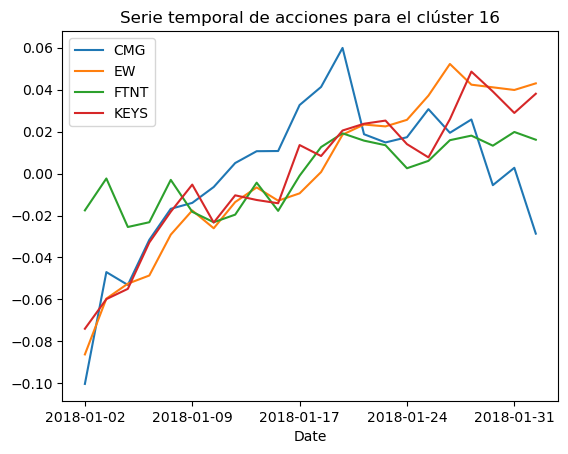

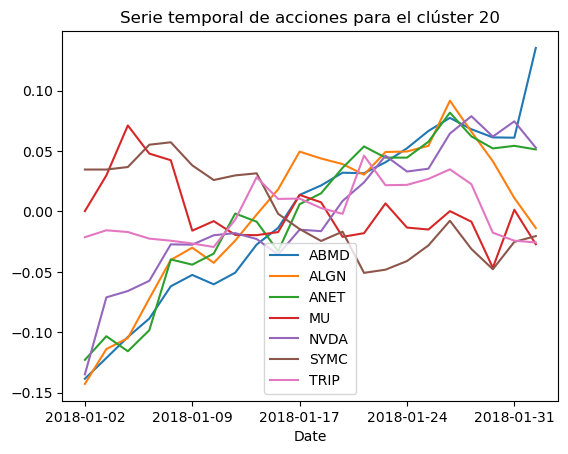

In [36]:
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:"2018-02-01", tickers].mean())
    data = np.log(dataset.loc[:"2018-02-01", tickers]).sub(means)
    data.plot(title='Serie temporal de acciones para el clúster %d' % clust)
plt.show()

Si observamos los gráficos anteriores, en todos los grupos con un pequeño número de acciones, vemos un movimiento similar de las acciones en diferentes grupos, lo que corrobora la eficacia de la técnica de agrupación.

<a id='6'></a>
# 6. Selección de pares

<a id='6.1'></a>
## 6.1. Función de cointegración y selección de pares

In [37]:
def find_cointegrated_pairs(data, significance=0.05):
    # introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [38]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [39]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [40]:
print ("Número de pares encontrados : %d" % len(pairs))
print ("En esos pares, hay %d tickers únicos." % len(np.unique(pairs)))

Número de pares encontrados : 32
En esos pares, hay 47 tickers únicos.


In [41]:
pairs

[('AOS', 'FITB'),
 ('AOS', 'ZION'),
 ('AIG', 'TEL'),
 ('ABBV', 'BWA'),
 ('ACN', 'EQIX'),
 ('AFL', 'ARE'),
 ('AFL', 'ED'),
 ('AFL', 'MMC'),
 ('AFL', 'WM'),
 ('A', 'WAT'),
 ('ADBE', 'ADI'),
 ('ADBE', 'CDNS'),
 ('ADBE', 'VFC'),
 ('ABT', 'AZO'),
 ('ABT', 'CHD'),
 ('ABT', 'IQV'),
 ('ABT', 'WELL'),
 ('ALL', 'GL'),
 ('MO', 'CCL'),
 ('ALB', 'CTL'),
 ('ALB', 'FANG'),
 ('ALB', 'EOG'),
 ('ALB', 'HP'),
 ('ALB', 'NOV'),
 ('ALB', 'PVH'),
 ('ALB', 'TPR'),
 ('ADSK', 'ULTA'),
 ('ADSK', 'XLNX'),
 ('AAL', 'FCX'),
 ('CMG', 'EW'),
 ('CMG', 'KEYS'),
 ('XEC', 'DXC')]

<a id='6.2'></a>
## 6.2. Visualización de pares

In [42]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [43]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [44]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

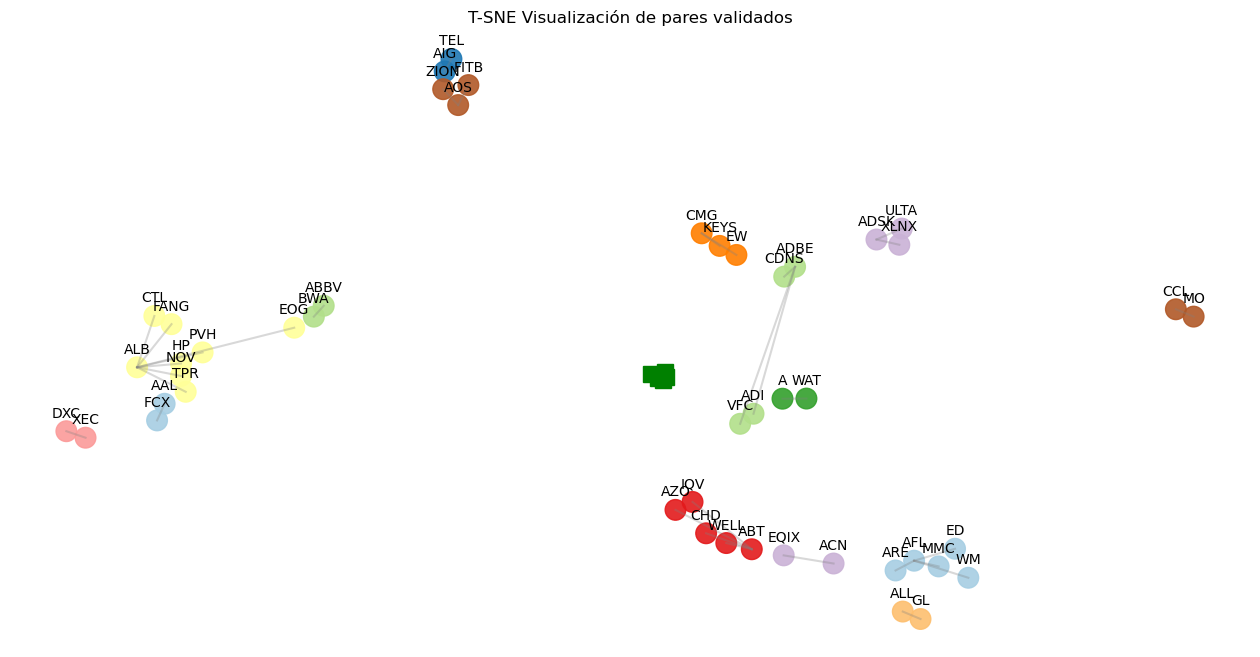

In [45]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:

    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]


    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualización de pares validados'); 

# zip une las coordenadas x e y en parejas
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # este es el texto
                 (x,y), # este es el punto a etiquetar
                 textcoords="offset points", # cómo posicionar el texto
                 xytext=(0,10), # distancia del texto a los puntos (x,y)
                 ha='center') 
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)


**Conclusión**

Las técnicas de agrupamiento no ayudan directamente en la predicción de la tendencia de las acciones. Sin embargo, se pueden utilizar eficazmente en la construcción de carteras para encontrar los pares adecuados, lo que eventualmente ayudará a mitigar el riesgo y se pueden lograr rendimientos superiores ajustados al riesgo.

Mostramos los enfoques para encontrar el número apropiado de conglomerados en k-medias y construimos un gráfico de jerarquía en agrupamiento jerárquico. El siguiente paso de este estudio de caso sería explorar y probar varias estrategias comerciales largas/cortas con pares de acciones de grupos de acciones.

La agrupación se puede utilizar eficazmente para dividir acciones en grupos con “características similares” para muchos otros tipos de estrategias comerciales y puede ayudar en la construcción de carteras para garantizar que elijamos un universo de acciones con suficiente diversificación entre ellas.